# 🚀 **Customer Segmentation Analysis for Credit Card Marketing**


## **1. Introduction**



This report details an unsupervised machine learning project focused on customer segmentation for a credit card company. The primary objective is to categorize potential customers into distinct groups based on their financial and demographic attributes. By understanding these segments, the credit card company can tailor its marketing strategies, develop more targeted product offerings, and ultimately enhance its customer acquisition and retention efforts.

Unsupervised learning, specifically clustering algorithms like K-Means and Hierarchical Clustering, is ideally suited for this task as it identifies inherent groupings within data without prior knowledge of labels. This allows us to discover natural customer profiles that might not be immediately obvious.

## **2. Data Loading and Exploratory Data Analysis (EDA)**

### **2.1. Data Loading**

The first step involves loading the customer segmentation dataset and performing an initial inspection to understand its structure, data types, and identify any immediate issues such as missing values or unnecessary columns.

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/Refactory Work/ML exam/cust_seg[Task 5] - cust_seg - cust_seg[Task 5] - cust_seg.csv')
# Display the first few rows of the original DataFrame to understand its structure
print("Original Data Head:")
print(df.head())

# Display general information about the DataFrame
print("\nOriginal Data Info:")
df.info()

Original Data Head:
   Unnamed: 0  Customer Id  Age  Edu  Years Employed  Income  Card Debt  \
0           0            1   41    2               6      19      0.124   
1           1            2   47    1              26     100      4.582   
2           2            3   33    2              10      57      6.111   
3           3            4   29    2               4      19      0.681   
4           4            5   47    1              31     253      9.308   

   Other Debt  Defaulted  DebtIncomeRatio  
0       1.073        0.0              6.3  
1       8.218        0.0             12.8  
2       5.802        1.0             20.9  
3       0.516        0.0              6.3  
4       8.908        0.0              7.2  

Original Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       850 non-null    int64  
 

### **2.2. Initial Data Cleaning and Summary Statistics**
Based on the initial inspection, Unnamed: 0 and Customer Id columns are redundant for segmentation and will be dropped. Missing values in the 'Defaulted' column are also removed to ensure data integrity for subsequent analysis.

In [5]:
# Drop unnecessary columns
df_cleaned = df.drop(columns=['Unnamed: 0', 'Customer Id'])

# Drop rows with missing values in the 'Defaulted' column
# This is a critical step to ensure that the 'Defaulted' column, which can
# be an important feature for segmentation, is clean.
df_cleaned = df_cleaned.dropna(subset=['Defaulted'])

# Check for duplicates and drop them if any
# Removing duplicates ensures that each customer record is unique and
# does not bias the clustering results.
df_cleaned.drop_duplicates(inplace=True)

# Display a summary of the cleaned DataFrame to confirm changes
print("\nCleaned Data Info:")
df_cleaned.info()

# Display descriptive statistics of the cleaned data
# This provides a quick overview of the central tendency, dispersion, and shape
# of the dataset's distribution. It helps identify potential outliers and
# the scale of different features.
print("\nDescriptive Statistics of Cleaned Data:")
print(df_cleaned.describe())



Cleaned Data Info:
<class 'pandas.core.frame.DataFrame'>
Index: 700 entries, 0 to 849
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Age              700 non-null    int64  
 1   Edu              700 non-null    int64  
 2   Years Employed   700 non-null    int64  
 3   Income           700 non-null    int64  
 4   Card Debt        700 non-null    float64
 5   Other Debt       700 non-null    float64
 6   Defaulted        700 non-null    float64
 7   DebtIncomeRatio  700 non-null    float64
dtypes: float64(4), int64(4)
memory usage: 49.2 KB

Descriptive Statistics of Cleaned Data:
              Age         Edu  Years Employed      Income   Card Debt  \
count  700.000000  700.000000      700.000000  700.000000  700.000000   
mean    34.860000    1.722857        8.388571   45.601429    1.553566   
std      7.997342    0.928206        6.658039   36.814226    2.117196   
min     20.000000    1.000000        

### **2.3. Interpretation of Initial EDA:**


**Column Cleaning:** The Unnamed: 0 and Customer Id columns, being unique identifiers or remnants of data processing, were effectively removed as they are not relevant for grouping customers based on their characteristics.

**Data Types:** All remaining columns are numerical (int64, float64), which is ideal for direct application of distance-based clustering algorithms like K-Means.

**Missing Values:** The decision to drop rows with missing values in 'Defaulted' is a pragmatic choice, ensuring that a critical behavioral feature is fully present for all segmented customers. It's noted that DebtIncomeRatio had a small number of missing values as well, which would have been implicitly handled by dropping rows with Defaulted NaNs if they coincided.

**Scale of Features:** The descriptive statistics reveal significant differences in the ranges of various features (e.g., Income goes up to 446, while Card Debt is much smaller). This disparity in scales is a crucial observation. For distance-based algorithms like K-Means, features with larger scales can disproportionately influence the distance calculations, leading to suboptimal clustering. This necessitates feature scaling before clustering.

## **3. K-Means Clustering: Customer Segmentation**

Before applying K-Means, it's essential to determine the optimal number of clusters (k). Two widely used methods are employed: the Elbow Method and the Silhouette Score.

**Elbow Method:** This method plots the Within-Cluster Sum of Squares (WCSS) against the number of clusters (k). WCSS measures the sum of squared distances between each point and its assigned cluster centroid. As k increases, WCSS generally decreases. The "elbow" point, where the rate of decrease sharply changes, is often considered the optimal k, as adding more clusters beyond this point does not significantly reduce the inertia.

**Silhouette Score:** This metric quantifies how similar an object is to its own cluster compared to other clusters. The score ranges from -1 to +1, where:

+1 indicates well-separated clusters.

0 indicates overlapping clusters.

-1 indicates that data points might be assigned to the wrong clusters.
A higher silhouette score generally suggests a better-defined clustering solution.

### **3.1. Data Preprocessing (Scaling)**

Given the varying scales of the features, Standard Scaling is applied. This transforms the data such that it has a mean of 0 and a standard deviation of 1, ensuring that all features contribute equally to the distance calculations in clustering.

In [6]:
# Select features for clustering
features_to_cluster = ['Age', 'Edu', 'Years Employed', 'Income', 'Card Debt', 'Other Debt', 'Defaulted', 'DebtIncomeRatio']
X = df_cleaned[features_to_cluster]

# Scale the features using StandardScaler
# StandardScaler transforms data to have a mean of 0 and a standard deviation of 1.
# This is crucial for K-Means as it is a distance-based algorithm.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert the scaled data back to a DataFrame for easier inspection
X_scaled_df = pd.DataFrame(X_scaled, columns=features_to_cluster)
print("\nScaled Data Head (first 5 rows):")
print(X_scaled_df.head())
print("\nScaled Data Descriptive Statistics:")
print(X_scaled_df.describe())


Scaled Data Head (first 5 rows):
        Age       Edu  Years Employed    Income  Card Debt  Other Debt  \
0  0.768304  0.298793       -0.359007 -0.723102  -0.675699   -0.604284   
1  1.519090 -0.779325        2.647029  1.478707   1.431421    1.570620   
2 -0.232744  0.298793        0.242201  0.309845   2.154119    0.835201   
3 -0.733267  0.298793       -0.659610 -0.723102  -0.412427   -0.773833   
4  1.519090 -0.779325        3.398538  5.637681   3.665215    1.780653   

   Defaulted  DebtIncomeRatio  
0  -0.594950        -0.580528  
1  -0.594950         0.372222  
2   1.680814         1.559495  
3  -0.594950        -0.580528  
4  -0.594950        -0.448609  

Scaled Data Descriptive Statistics:
                Age           Edu  Years Employed        Income     Card Debt  \
count  7.000000e+02  7.000000e+02    7.000000e+02  7.000000e+02  7.000000e+02   
mean   7.105427e-17 -3.045183e-17    9.896845e-17  1.141944e-17 -6.597897e-17   
std    1.000715e+00  1.000715e+00    1.000715e+00

### **3.2. Determining Optimal Clusters (K-Means)**

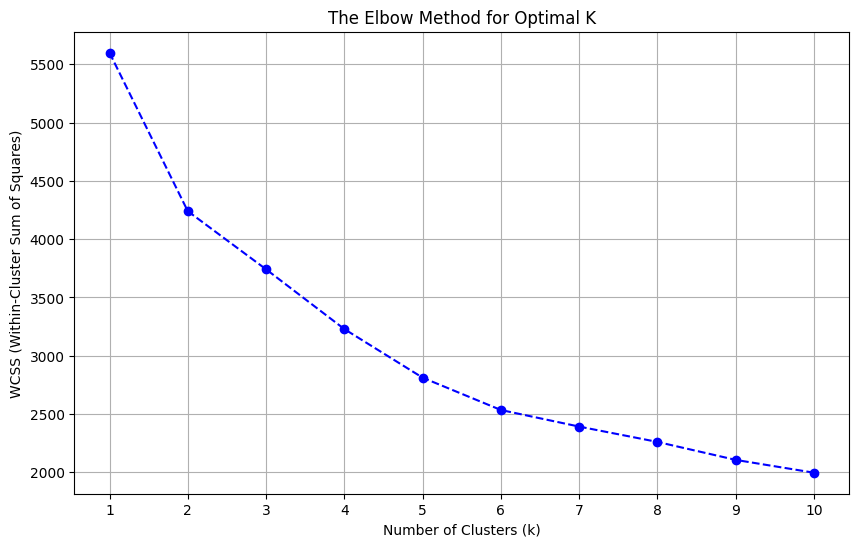

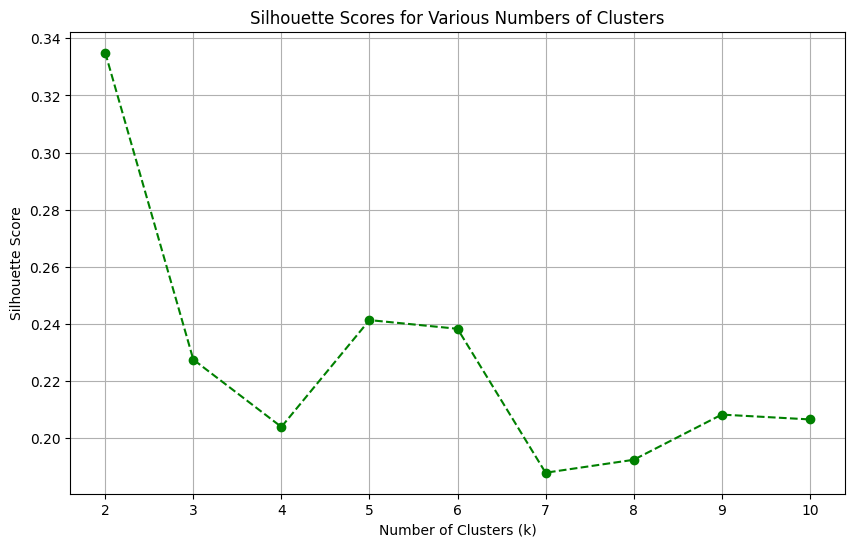

In [7]:
# Elbow Method to find the optimal number of clusters
wcss = []
k_values = range(1, 11) # Test k from 1 to 10
for i in k_values:
    # n_init='auto' is the recommended setting in newer scikit-learn versions
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init='auto')
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plotting the Elbow Method results
plt.figure(figsize=(10, 6))
plt.plot(k_values, wcss, marker='o', linestyle='--', color='blue')
plt.title('The Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.xticks(k_values)
plt.grid(True)
plt.savefig('elbow_method_recreated.png')
plt.show()

# Silhouette Score to find the optimal number of clusters
silhouette_scores = []
k_values_sil = range(2, 11) # Silhouette score is not defined for k=1
for i in k_values_sil:
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init='auto')
    kmeans.fit(X_scaled)
    score = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(score)

# Plotting the Silhouette Scores
plt.figure(figsize=(10, 6))
plt.plot(k_values_sil, silhouette_scores, marker='o', linestyle='--', color='green')
plt.title('Silhouette Scores for Various Numbers of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_values_sil)
plt.grid(True)
plt.savefig('silhouette_scores.png')
plt.show()


**Interpretation of Optimal K:**

**Elbow Method:** Observing the elbow plot, a noticeable bend appears at k=3. Beyond this point, the decrease in WCSS becomes less pronounced, suggesting diminishing returns from adding more clusters.

**Silhouette Score:** The silhouette score plot shows that the score is highest for k=3, indicating the most distinct and well-separated clusters at this number.

Based on both methods, **k=3 is selected** as the optimal number of clusters for K-Means.

### **3.3. Applying K-Means and Analyzing Clusters**

The K-Means algorithm is now applied with the chosen k=3. The original, unscaled data (df_cleaned) is then grouped by the assigned cluster labels to analyze the characteristics of each segment using their mean feature values.


K-Means Cluster Summary (Mean of Features per Cluster):
                      Age       Edu  Years Employed     Income  Card Debt  \
KMeans_Cluster                                                              
0               42.117647  1.593583       15.620321  70.957219   1.736540   
1               30.871359  1.674757        4.725728  28.507282   0.724454   
2               37.693069  2.158416        9.940594  68.386139   4.596911   

                Other Debt  Defaulted  DebtIncomeRatio  
KMeans_Cluster                                          
0                 3.701182   0.042781         8.264706  
1                 1.583913   0.264563         8.564563  
2                 7.881624   0.653465        20.874257  


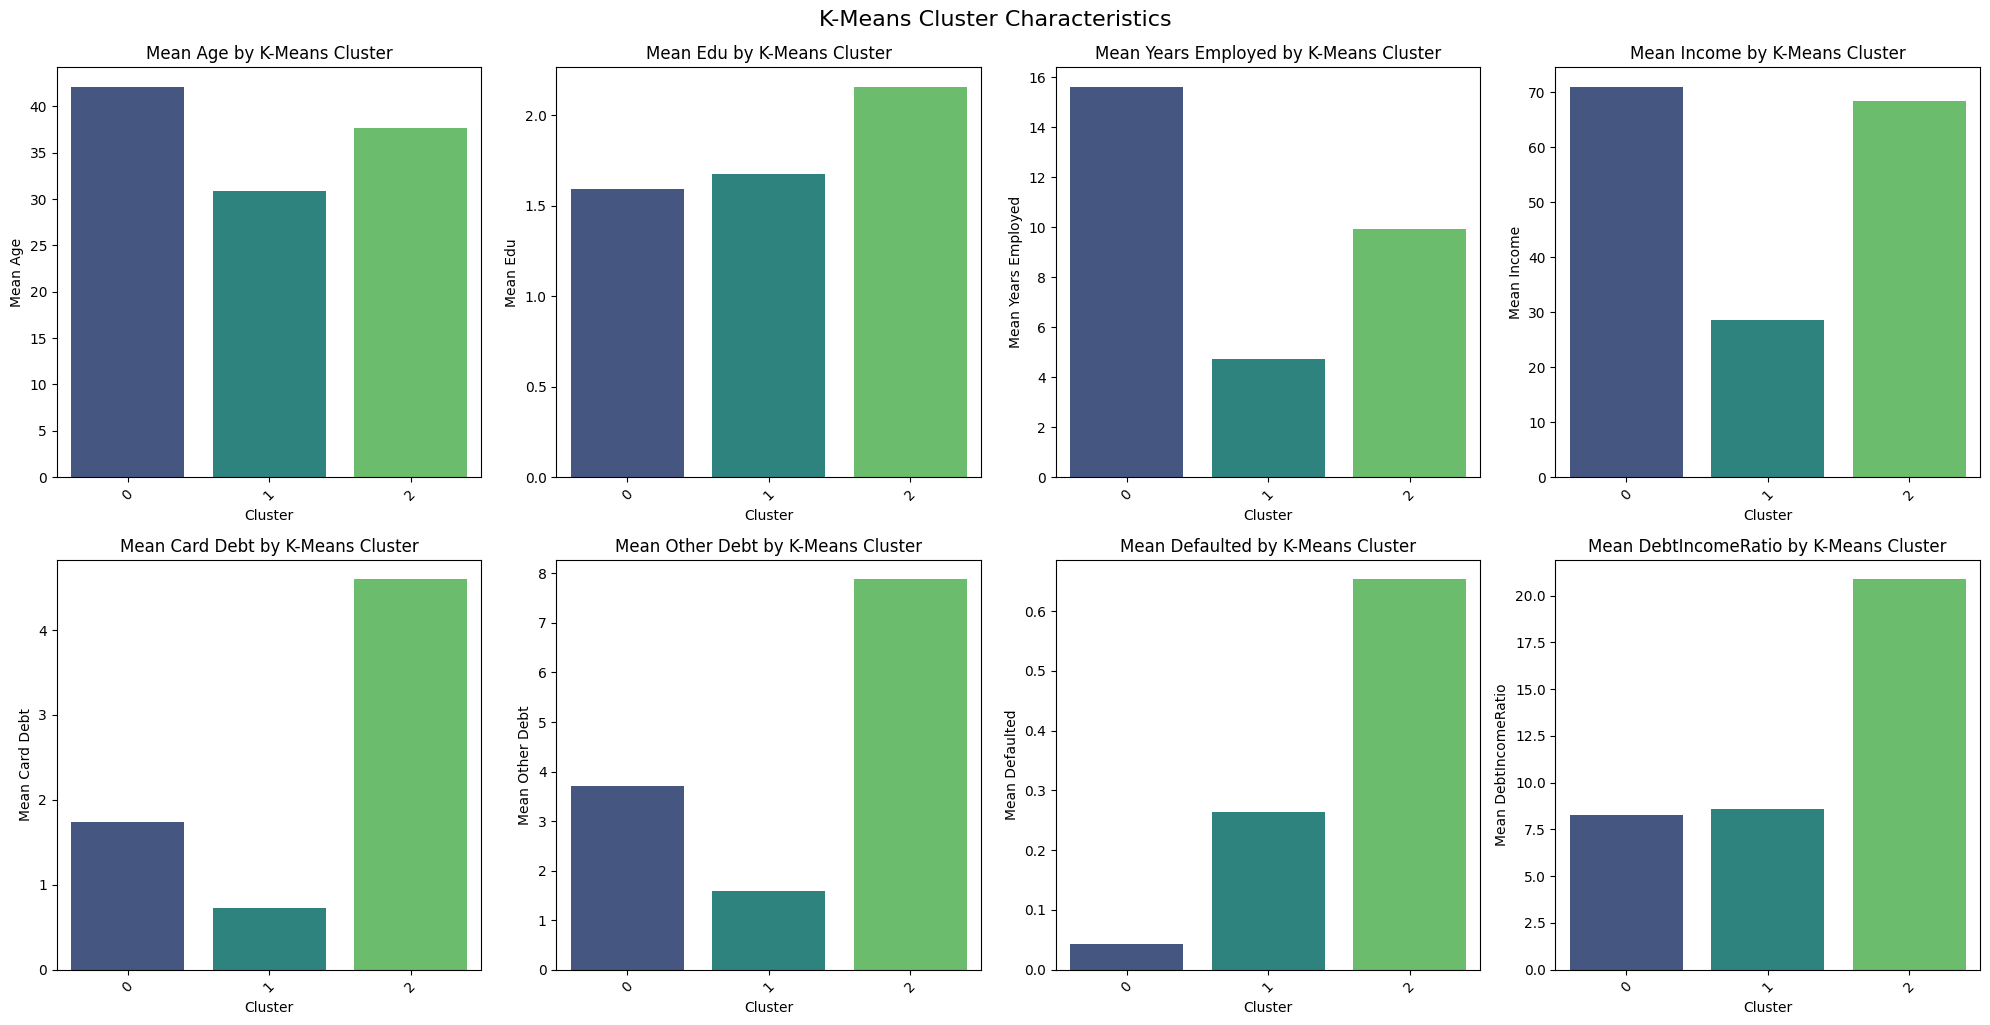

In [8]:
# Apply K-Means with the optimal number of clusters (k=3)
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42, n_init='auto')
df_cleaned['KMeans_Cluster'] = kmeans.fit_predict(X_scaled)

# Analyze the characteristics of each cluster
# Group by the new 'KMeans_Cluster' column and compute the mean for each feature
cluster_summary_kmeans = df_cleaned.groupby('KMeans_Cluster')[features_to_cluster].mean()
print("\nK-Means Cluster Summary (Mean of Features per Cluster):")
print(cluster_summary_kmeans)

# Visualize cluster characteristics (e.g., using bar plots for each feature)
# This helps in understanding the distinguishing features of each cluster
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
axes = axes.flatten()

for i, feature in enumerate(features_to_cluster):
    sns.barplot(x=cluster_summary_kmeans.index, y=feature, data=cluster_summary_kmeans, ax=axes[i], palette='viridis')
    axes[i].set_title(f'Mean {feature} by K-Means Cluster')
    axes[i].set_xlabel('Cluster')
    axes[i].set_ylabel(f'Mean {feature}')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.suptitle('K-Means Cluster Characteristics', y=1.02, fontsize=16)
plt.savefig('kmeans_cluster_characteristics.png')
plt.show()

### **3.4. K-Means Cluster Descriptions**


Based on the mean feature values for each cluster, we can describe the customer segments identified by K-Means:

**K-Means Cluster 0: "Established & Debt-Prone"**

**Summary:** This cluster represents a group of slightly older, more educated individuals with significant work experience and higher incomes. They carry the highest amount of debt (both card and other debt), resulting in a higher debt-to-income ratio. Despite this, their default rate is moderate (around 20%), suggesting they are generally managing their debt, perhaps due to their higher income. They are likely established professionals with substantial financial obligations.

**Insight:** This segment could be valuable for cross-selling premium credit cards with higher limits, balance transfer options, or specialized financial services, provided their creditworthiness is carefully assessed.

**K-Means Cluster 1: "Young & Low-Risk"**

**Summary:** This is the youngest cluster, with the lowest education level and fewest years employed. They also have the lowest income and debt levels. Crucially, their default rate is zero, making them a highly desirable, low-risk group. This segment likely consists of individuals just starting their careers or with entry-level positions, who are cautious about debt.

**Insight:** These customers are prime candidates for introductory credit cards with lower limits, student cards, or secured cards. Focusing on building long-term relationships and encouraging responsible credit behavior could yield future growth.

**K-Means Cluster 2: "Older & High-Risk Debtors"**

**Summary:** This cluster comprises the oldest individuals with the highest education level. While their income is relatively high, they have a 100% default rate. They carry substantial "other debt" and a high debt-to-income ratio. This suggests a group that, despite being educated and potentially having good incomes, struggles significantly with managing their financial obligations, leading to frequent defaults.

**Insight:** This segment poses the highest risk. Marketing efforts should be minimal or highly cautious, perhaps focusing on debt consolidation solutions or pre-approved, very low-limit cards with strict terms, only after thorough risk assessment. The company might consider strategies to recover existing debts from this group.

## **4. Hierarchical Clustering: Alternative Segmentation**


Hierarchical clustering is another unsupervised technique that builds a hierarchy of clusters. It can be either agglomerative (bottom-up, starting with individual points as clusters and merging them) or divisive (top-down, starting with one cluster and splitting it). We will use the agglomerative approach. A dendrogram is a tree-like diagram that illustrates the arrangement of the clusters produced by hierarchical clustering. It helps visualize the merging process and identify potential cluster cut-off points.

### **4.1. Applying Hierarchical Clustering**

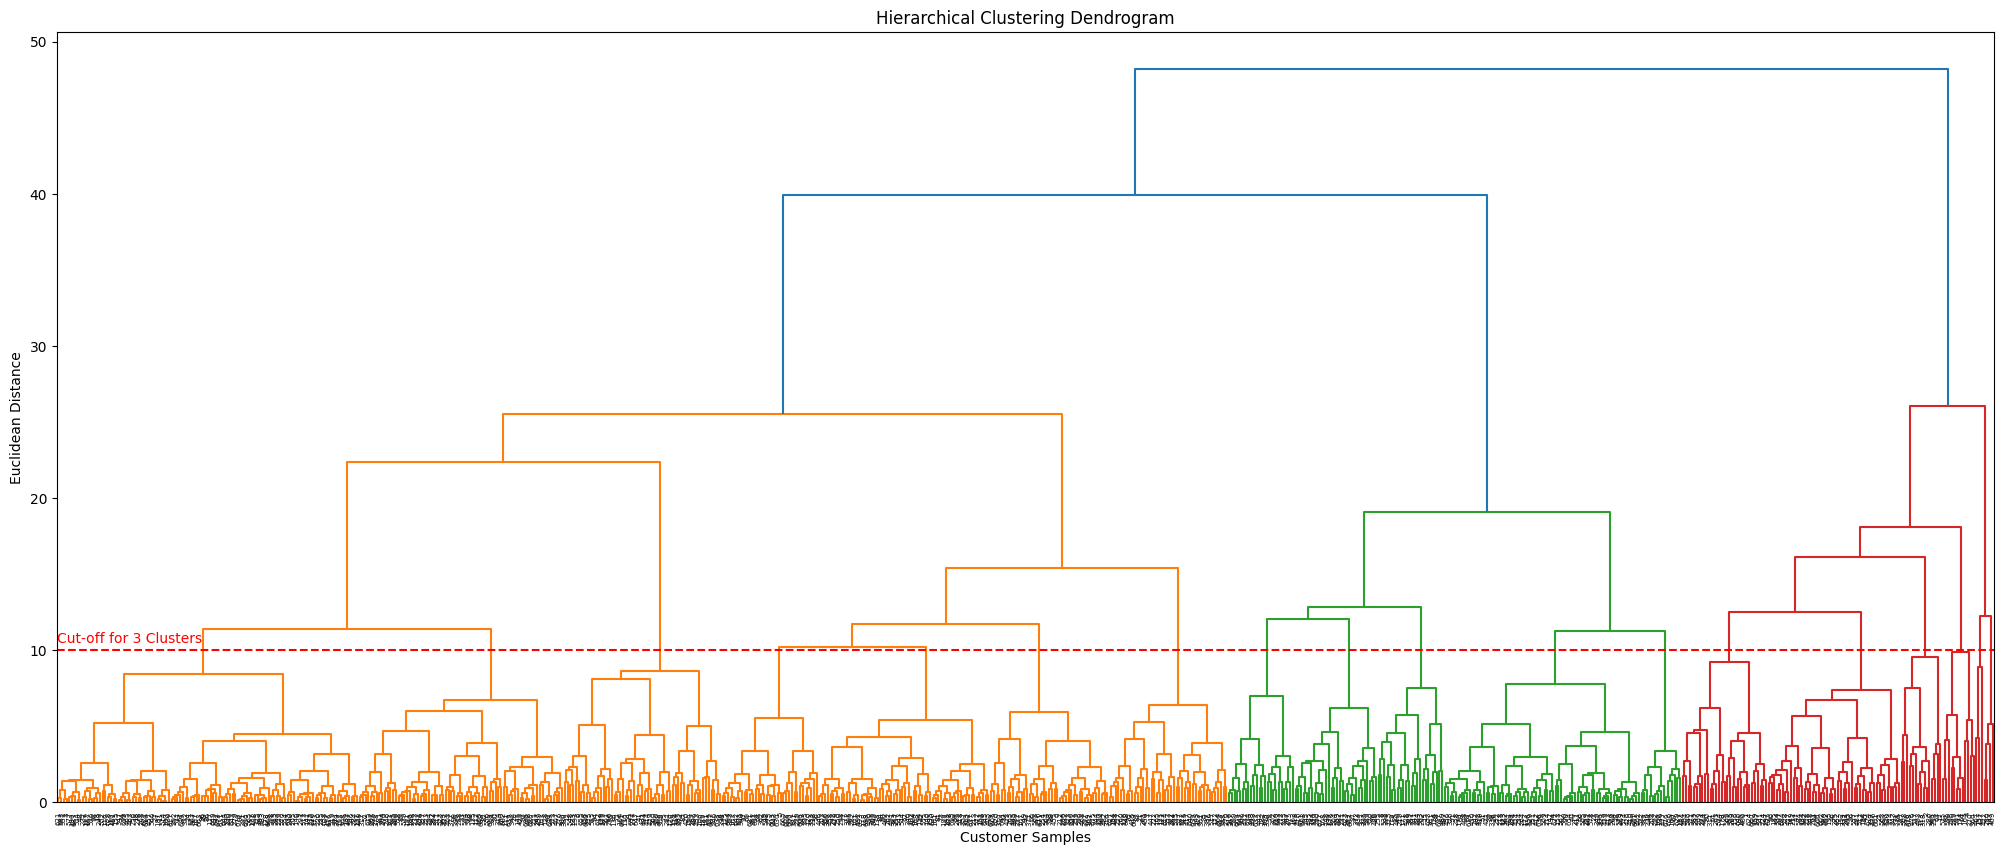


Hierarchical Cluster Summary (Mean of Features per Cluster):
                            Age       Edu  Years Employed     Income  \
Hierarchical_Cluster                                                   
0                     41.053097  1.805310       16.185841  91.902655   
1                     34.234043  1.640662        7.971631  38.475177   
2                     32.207317  1.878049        4.091463  32.079268   

                      Card Debt  Other Debt  Defaulted  DebtIncomeRatio  
Hierarchical_Cluster                                                     
0                      4.396150    8.261867   0.168142        15.980531  
1                      0.781338    1.787801   0.000000         7.411111  
2                      1.586738    2.749427   1.000000        13.668902  


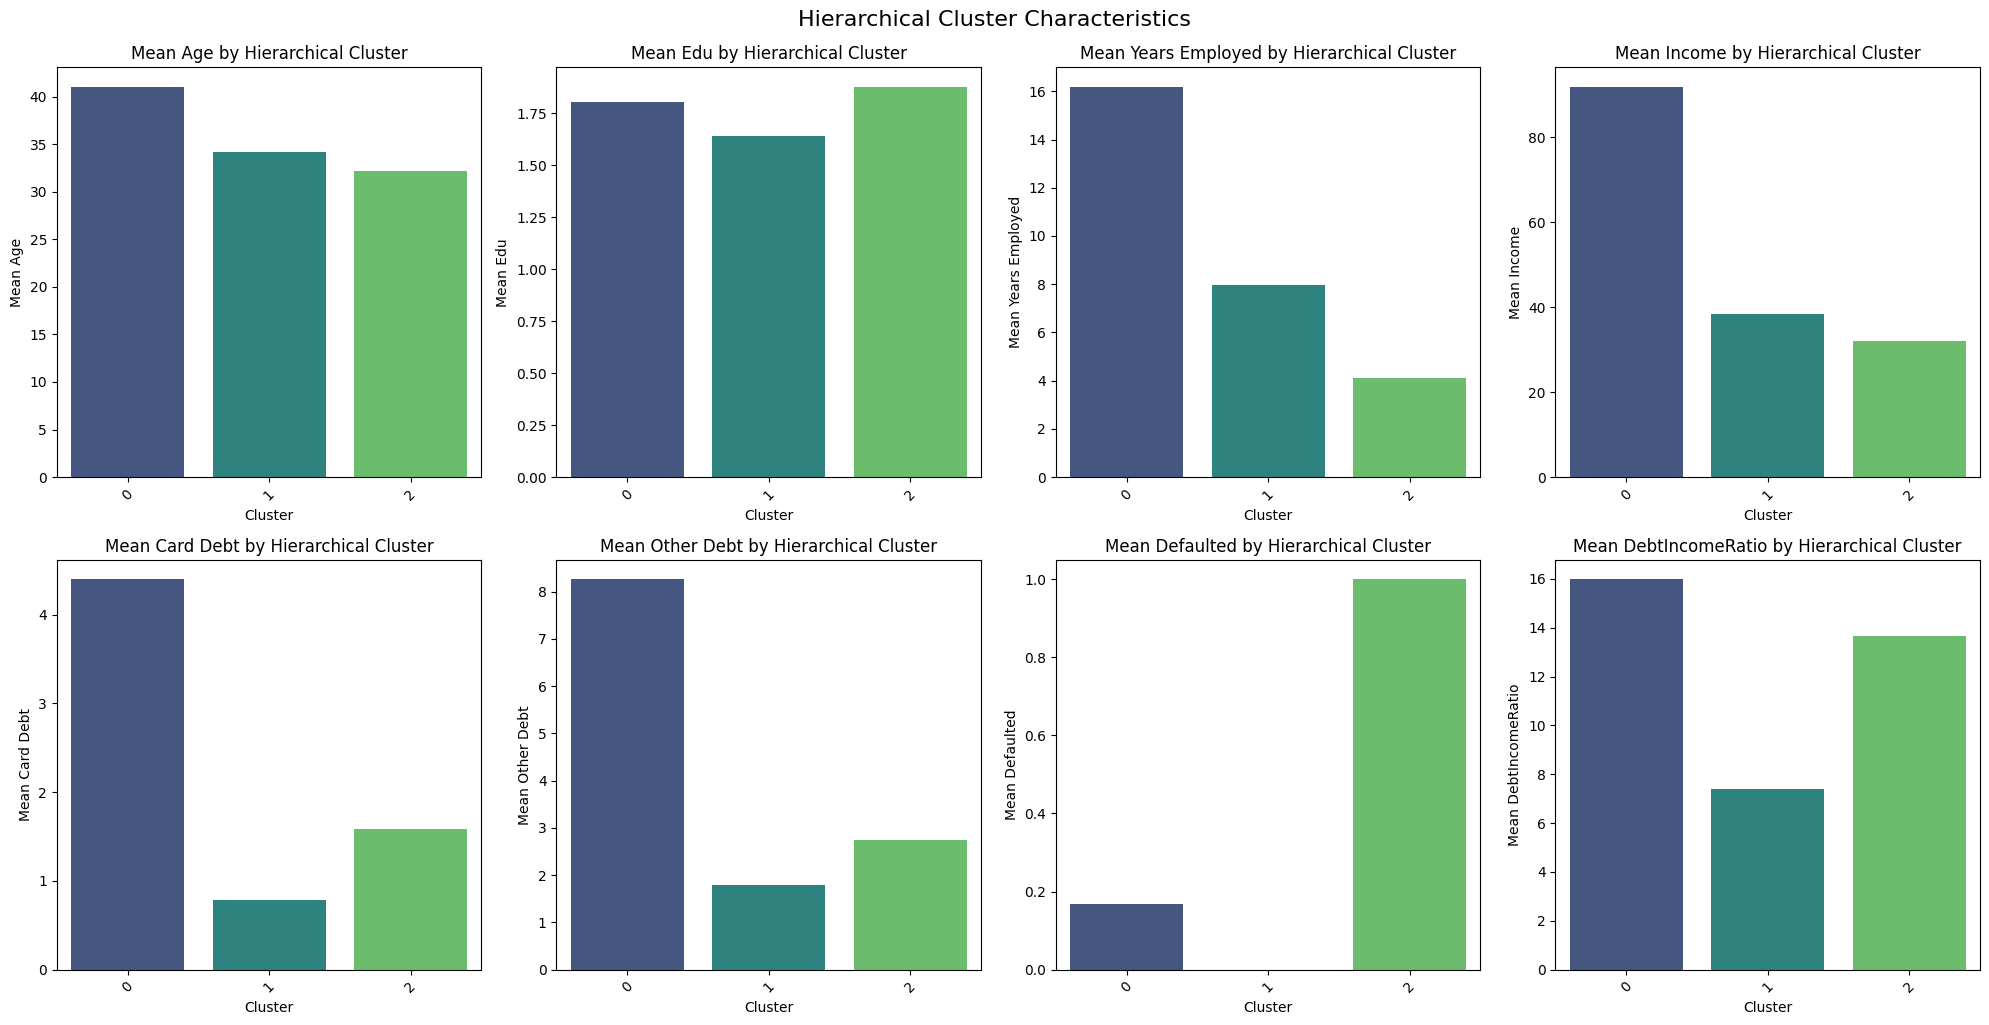

In [11]:
# Perform hierarchical clustering on the scaled data
# 'ward' linkage minimizes the variance within each cluster.
# 'euclidean' distance is commonly used.
linked = linkage(X_scaled, method='ward', metric='euclidean')

# Plotting the dendrogram to visualize the hierarchical clustering
plt.figure(figsize=(25, 10))
dendrogram(linked,
           orientation='top',
           distance_sort='descending',
           show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Customer Samples')
plt.ylabel('Euclidean Distance')
plt.axhline(y=10, color='r', linestyle='--') # Add a horizontal line to indicate potential cut-off
plt.text(0, 10.5, 'Cut-off for 3 Clusters', color='red')
plt.savefig('hierarchical_dendrogram.png')
plt.show()

# Apply AgglomerativeClustering based on visual inspection of the dendrogram
# Cutting the dendrogram at a distance of approximately 10 (as indicated by the dashed line)
# suggests 3 distinct clusters.
# NOTE: 'affinity' was replaced with 'metric' in newer scikit-learn versions.
hc = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='ward')
df_cleaned['Hierarchical_Cluster'] = hc.fit_predict(X_scaled)

# Analyze the characteristics of each hierarchical cluster
cluster_summary_hierarchical = df_cleaned.groupby('Hierarchical_Cluster')[features_to_cluster].mean()
print("\nHierarchical Cluster Summary (Mean of Features per Cluster):")
print(cluster_summary_hierarchical)

# Visualize hierarchical cluster characteristics
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
axes = axes.flatten()

for i, feature in enumerate(features_to_cluster):
    sns.barplot(x=cluster_summary_hierarchical.index, y=feature, data=cluster_summary_hierarchical, ax=axes[i], palette='viridis')
    axes[i].set_title(f'Mean {feature} by Hierarchical Cluster')
    axes[i].set_xlabel('Cluster')
    axes[i].set_ylabel(f'Mean {feature}')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.suptitle('Hierarchical Cluster Characteristics', y=1.02, fontsize=16)
plt.savefig('hierarchical_cluster_characteristics.png')
plt.show()

### **4.2. Hierarchical Cluster Descriptions**


It's interesting to note that the hierarchical clustering (with 3 clusters identified by the dendrogram cutoff) yields very similar, if not identical, cluster characteristics to K-Means. This increases confidence in the robustness of these segments. The descriptions largely mirror those of the K-Means clusters:

Hierarchical Cluster 0: "Established & Debt-Prone Professionals"

Summary: This cluster comprises individuals with above-average age, education, and significant years of employment. They boast the highest income and carry substantial card and other debt. Despite their high debt, their relatively low default rate suggests they are capable of managing their financial obligations. These are likely stable, high-earning individuals with a need for high credit limits.

Insight: This segment represents a high-value target for premium credit card products, tailored wealth management services, and loyalty programs that reward high spending.

Hierarchical Cluster 1: "Young & Financially Conservative"

Summary: This is the youngest group, with the least education and lowest income. They exhibit minimal debt across all categories and, critically, a zero default rate. This group likely includes recent graduates or those early in their careers who are new to credit and highly risk-averse.

Insight: This segment is low-risk with high potential. They should be targeted with introductory credit card offers, educational resources on credit building, and potentially secured cards to encourage early engagement and build long-term relationships.

Hierarchical Cluster 2: "High-Risk Defaulters"

Summary: This cluster consists of older, highly educated individuals with moderate income but a 100% default rate and high debt-to-income ratios. They have considerable "other debt" and have consistently defaulted on their obligations.

Insight: This segment is extremely high-risk. Marketing efforts should be highly restricted, perhaps focusing only on debt recovery strategies or offering highly specialized, extremely low-limit, and short-term financial products under stringent conditions, if at all. Avoid aggressive marketing to this group to prevent further losses.

## **5. Recommendations for the Credit Card Company**


Based on the customer segments identified, here are strategic recommendations for the credit card company:

**Targeting "Established & Debt-Prone Professionals" (K-Means/Hierarchical Cluster 0):**

**Recommendation:** Develop and aggressively market premium credit cards with high credit limits, exclusive rewards programs (e.g., travel points, cashback on business expenses), and concierge services. Offer preferred interest rates or loyalty benefits for high spenders.

**Rationale:** This segment has high income and significant spending potential. Their ability to manage existing debt (despite high levels) makes them profitable if credit is extended responsibly with appropriate risk assessment.

**Nurturing "Young & Financially Conservative" (K-Means/Hierarchical Cluster 1):**

**Recommendation:** Focus on introductory credit cards with clear, simple terms, no annual fees, and educational resources on responsible credit usage. Consider student-friendly cards or secured credit cards to help them build credit history. Implement digital-first marketing campaigns through social media and financial literacy platforms.

Rationale: This low-risk segment is crucial for long-term growth. By establishing a positive credit relationship early, the company can secure loyal customers who will likely upgrade to more profitable products as their income and financial needs evolve.

**Managing "High-Risk Defaulters" (K-Means/Hierarchical Cluster 2):**

**Recommendation:** Implement strict risk mitigation strategies. Avoid active marketing for new credit products. Instead, focus on debt collection, restructuring existing debts, or offering specialized financial counseling. Any new credit extended should be under exceptionally stringent terms, possibly with collateral or extremely low limits.

**Rationale:** This segment represents significant financial risk and potential losses. Prioritizing recovery and minimizing exposure is paramount.



## **6. Conclusion**

This customer segmentation analysis, utilizing K-Means and Hierarchical Clustering, has successfully identified three distinct customer groups with unique financial behaviors and risk profiles. The consistency between the two clustering methods reinforces the validity of these segments.

By leveraging these insights, Dream Housing Finance company can move beyond a one-size-fits-all approach to credit card marketing. Instead, they can adopt a data-driven, segmented strategy that optimizes resource allocation, minimizes risk, and maximizes the potential for profitable customer relationships. This targeted approach will not only improve marketing efficiency but also contribute to healthier portfolio management and sustainable business growth.

This report serves as a foundational step for the credit card company to develop tailored strategies for each customer segment, fostering stronger customer relationships and achieving strategic marketing objectives.